In [26]:
import scanpy as sc
import muon as mu
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.data import Data
from torch_geometric.transforms import RandomNodeSplit, RandomLinkSplit
from torch_geometric.loader import DataLoader, NeighborLoader

# Read data

In [2]:
t_commit_datafile = "/home/wuxinchao/data/st_cite_data/10x_cite_seq/data_storage/GSE158769_exprs_raw.tsv.gz"
t_commit_metafile = "/home/wuxinchao/data/st_cite_data/10x_cite_seq/data_storage/GSE158769_meta_data.txt.gz"

adata = sc.read_text(t_commit_datafile, delimiter='\t')
metadata = pd.read_csv(t_commit_metafile, sep='\t', index_col=0)
csr_mtx = adata.X
csr_mtx = csr_mtx.T
adata = sc.AnnData(X=csr_mtx, obs=adata.var, var=adata.obs)
adata.obs = metadata.loc[adata.obs.index, :]
adata.obs.head()

,nUMI,nGene,percent_mito,batch,TB_status,UMAP_1,UMAP_2,cluster_name,cluster_ids,donor,age,sex,season,prop_NAT
AAACCCAAGGCCTAAG-1,6108,1557,0.055828,1,CASE,-2.743703,1.617194,CD4+ CD27+,C-2,TB3419057,74,F,Summer,0.957475
AAACCCAAGGTTCTTG-1,7902,2149,0.083017,1,CASE,-4.237045,0.306832,CD4+ CCR4+ central,C-3,TB3419057,74,F,Summer,0.957475
AAACCCAAGTGCAGGT-1,5033,1788,0.129744,1,CASE,-1.136187,-4.012949,CD4+ Treg,C-9,TB3419057,74,F,Summer,0.957475
AAACCCACAAGAGTAT-1,6574,1747,0.066930,1,CASE,-1.015078,3.789505,CD4+ CD27+CD161+,C-4,TB3419057,74,F,Summer,0.957475
AAACCCACACACGGTC-1,6471,1872,0.047442,1,CASE,0.658381,2.427080,CD4+ Th17/1,C-13,TB0610655,41,M,Summer,0.975371


In [3]:
prot = adata[:, adata.var_names.str[-8:] == '_protein']
rna = adata[:, adata.var_names.str[-8:] != '_protein']
mdata = mu.MuData({'rna': rna, 'prot': prot})

In [3]:
mdata = mu.read_h5mu("../../totalVI/tcommit_downsampled.h5mu")

In [8]:
rna = mdata.mod["rna"]
prot = mdata.mod["prot"]

# RNA preprocessing

In [9]:
sc.pp.normalize_total(rna)
sc.pp.log1p(rna)
rna.obs_names_make_unique()
rna.var['mt'] = rna.var_names.str.startswith('MT-')
rna.layers["counts"] = rna.X.copy()
sc.pp.highly_variable_genes(
    mdata.mod["rna"],
    n_top_genes=2000,
    flavor="seurat_v3",
    layer="counts",
)

/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


In [10]:
mdata.mod["rna"] = mdata.mod["rna"][
    :, mdata.mod["rna"].var["highly_variable"]
]

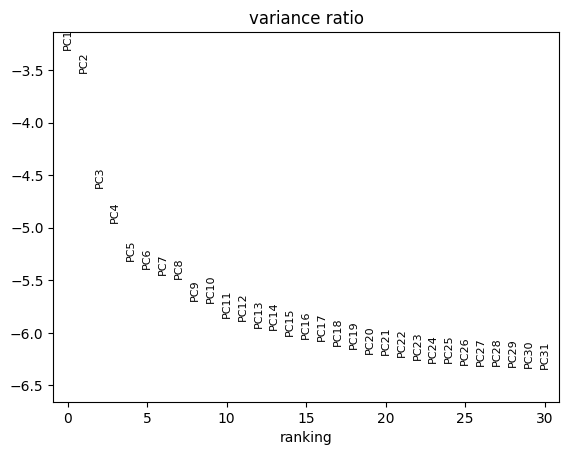

In [11]:
sc.pp.scale(rna, max_value=10)
sc.tl.pca(rna, svd_solver="arpack")
sc.pl.pca_variance_ratio(rna, log=True)

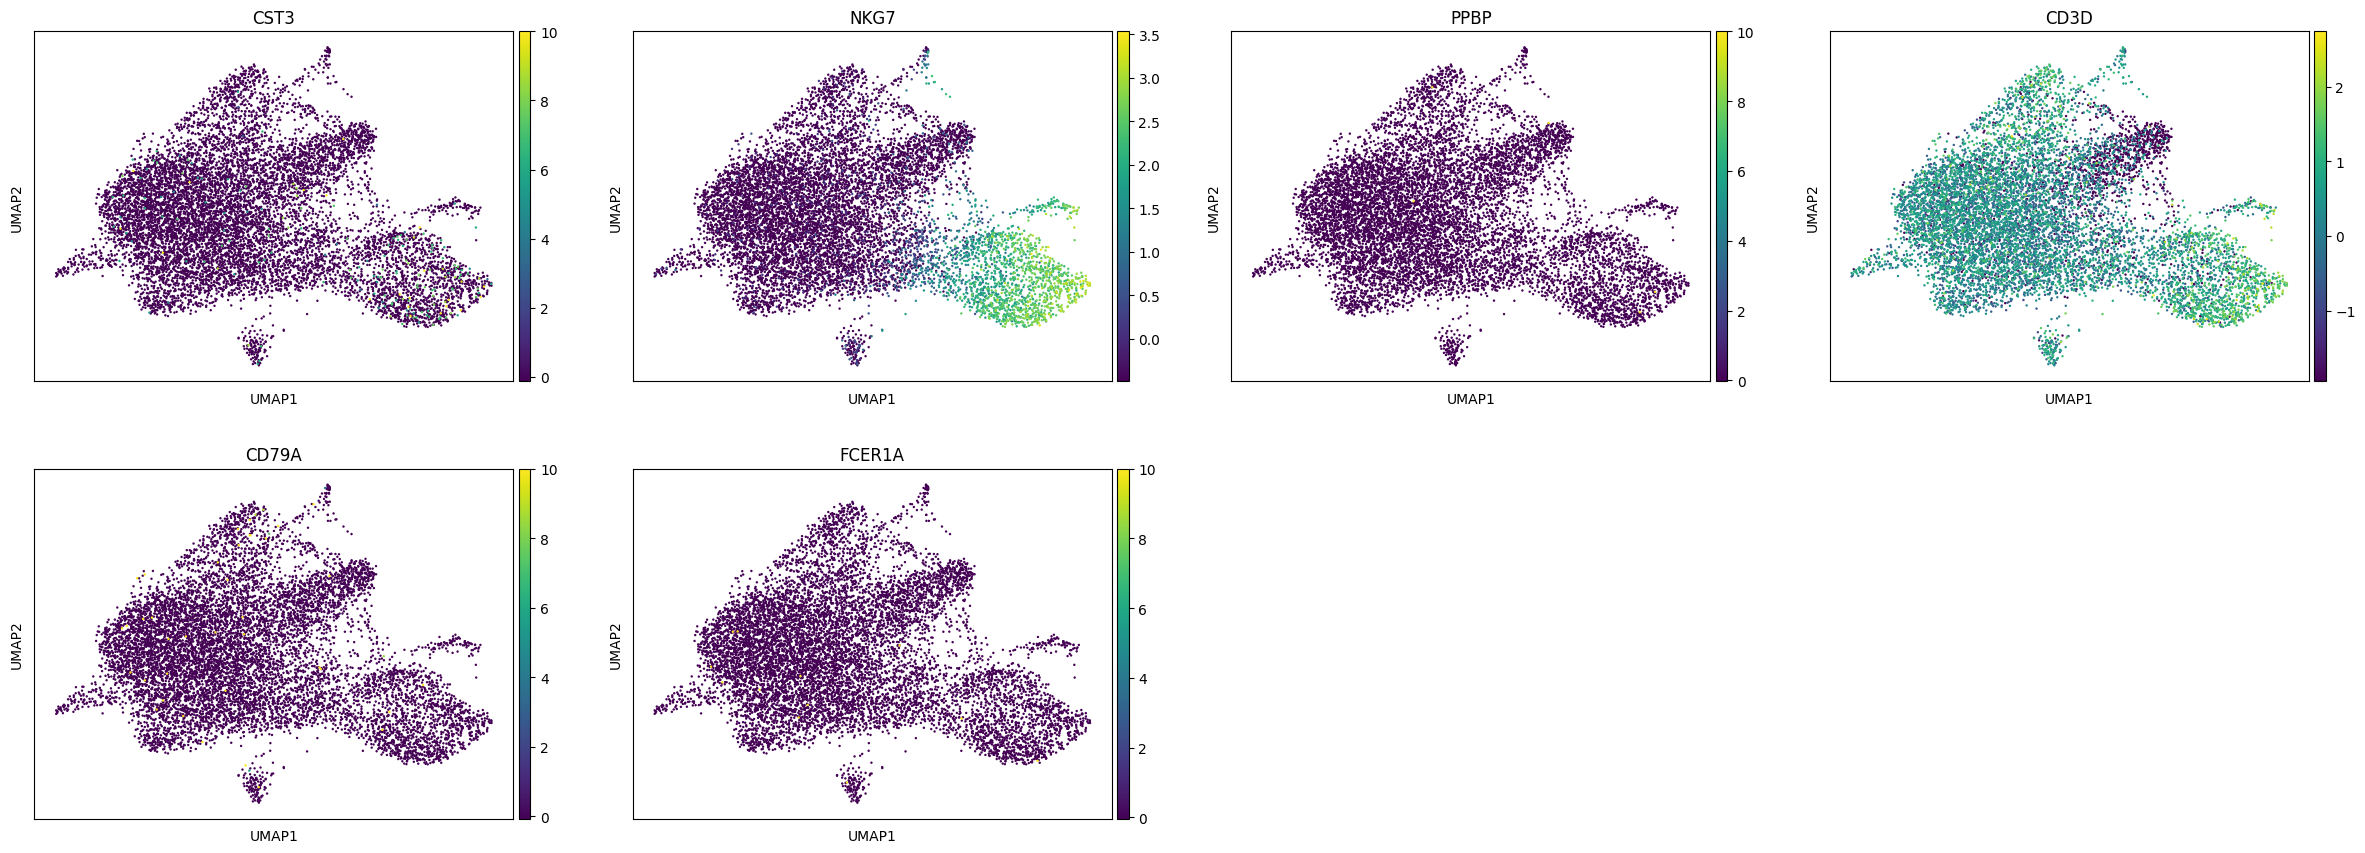

In [13]:
sc.pp.neighbors(rna, n_pcs=50)
sc.tl.umap(rna)
sc.pl.umap(rna, color=["CST3", "NKG7", "PPBP", "CD3D", "CD79A", "FCER1A"])

/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


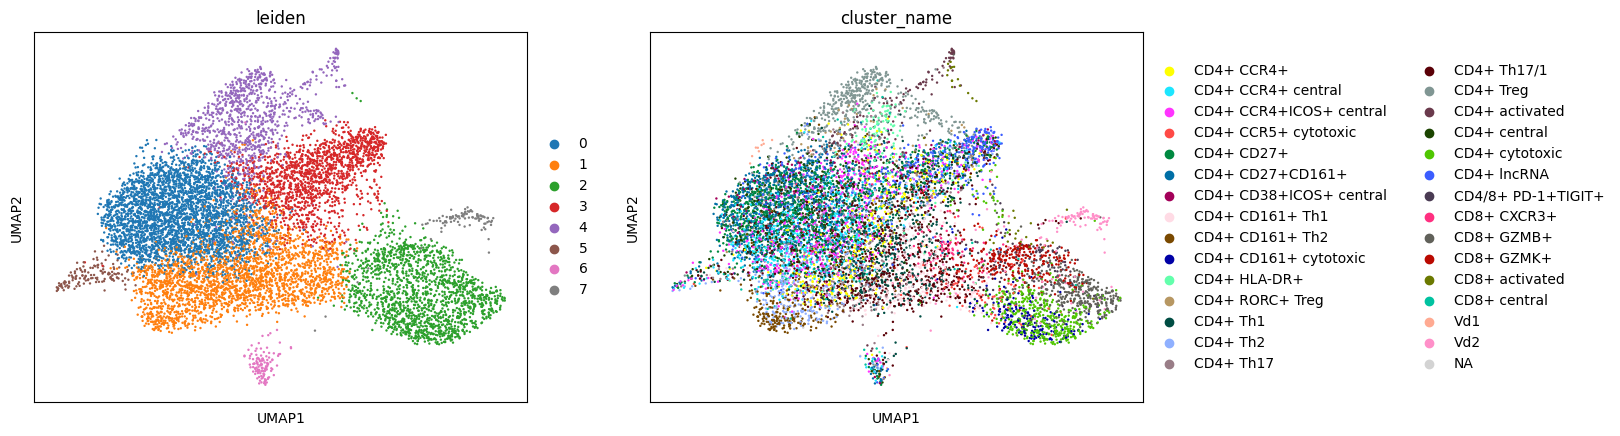

In [14]:
sc.tl.leiden(rna, resolution=0.5)
sc.pl.umap(rna, color=["leiden", "cluster_name"])

/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/scanpy/tools/_rank_

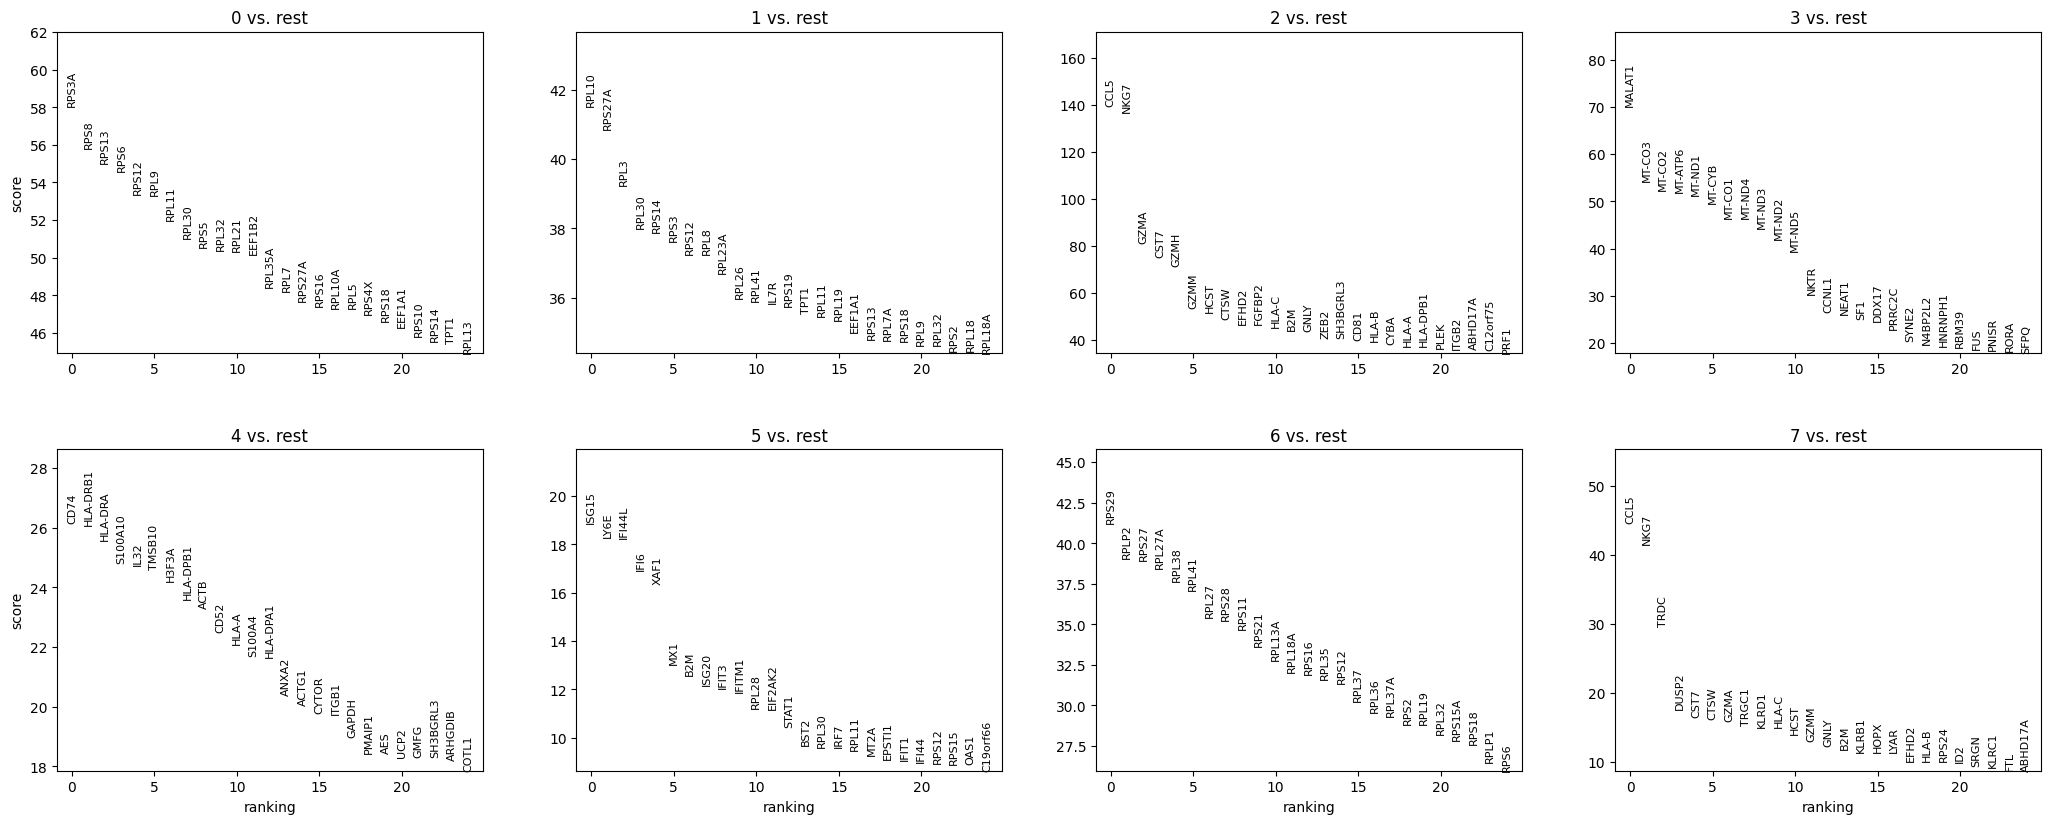

In [15]:
sc.tl.rank_genes_groups(rna, 'leiden', method='t-test')
sc.pl.rank_genes_groups(rna, n_genes=25, sharey=False)

In [16]:
result = rna.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.set_option('display.max_columns', 50)
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(10)

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,5_n,5_p,6_n,6_p,7_n,7_p
0,RPS3A,0.0,RPL10,0.000000e+00,CCL5,0.000000e+00,MALAT1,0.000000e+00,CD74,2.182897e-117,ISG15,1.221546e-39,RPS29,1.035321e-78,CCL5,4.937931e-71
1,RPS8,0.0,RPS27A,0.000000e+00,NKG7,0.000000e+00,MT-CO3,0.000000e+00,HLA-DRB1,1.132542e-115,LY6E,1.486371e-38,RPLP2,1.710734e-77,NKG7,9.172775e-66
2,RPS13,0.0,RPL3,0.000000e+00,GZMA,0.000000e+00,MT-CO2,0.000000e+00,HLA-DRA,8.925794e-112,IFI44L,2.916819e-38,RPS27,6.132529e-77,TRDC,6.478896e-50
3,RPS6,0.0,RPL30,2.650638e-295,CST7,0.000000e+00,MT-ATP6,0.000000e+00,S100A10,8.321682e-110,IFI6,3.828357e-35,RPL27A,3.354080e-75,DUSP2,4.961649e-32
4,RPS12,0.0,RPS14,1.052005e-293,GZMH,0.000000e+00,MT-ND1,0.000000e+00,IL32,1.711944e-109,XAF1,7.452667e-34,RPL38,2.641547e-72,CST7,7.022234e-30
5,RPL9,0.0,RPS3,7.258376e-290,GZMM,0.000000e+00,MT-CYB,0.000000e+00,TMSB10,4.259788e-109,MX1,1.076035e-25,RPL41,1.814003e-75,CTSW,2.732165e-29
6,RPL11,0.0,RPS12,1.552105e-284,HCST,0.000000e+00,MT-CO1,0.000000e+00,H3F3A,9.583064e-106,B2M,2.901395e-25,RPL27,3.186828e-71,GZMA,9.949840e-29
7,RPL30,0.0,RPL8,7.585744e-282,CTSW,0.000000e+00,MT-ND4,3.754899e-322,HLA-DPB1,5.443050e-100,ISG20,1.372348e-23,RPS28,1.166348e-71,TRGC1,1.613140e-27
8,RPS5,0.0,RPL23A,1.320911e-276,EFHD2,7.781740e-310,MT-ND3,4.930409e-302,ACTB,6.181979e-100,IFIT3,3.685928e-23,RPS11,7.308186e-69,KLRD1,5.475222e-27
9,RPL32,0.0,RPL26,8.620167e-267,FGFBP2,9.893161e-300,MT-ND2,4.708412e-279,CD52,3.394907e-94,IFITM1,8.474308e-23,RPS21,4.411649e-66,HLA-C,1.743982e-27


In [17]:
mdata.update()

# Protein Preprocessing

In [18]:
from muon import prot as pt

In [19]:
pt.pp.clr(prot)
mdata.update()

In [20]:
mdata.write_h5mu("../data/t_commit.h5mu")

# model training

In [21]:
mdata

MuData object with n_obs × n_vars = 10000 × 2031
  2 modalities
    rna:	10000 x 2000
      obs:	'nUMI', 'nGene', 'percent_mito', 'batch', 'TB_status', 'UMAP_1', 'UMAP_2', 'cluster_name', 'cluster_ids', 'donor', 'age', 'sex', 'season', 'prop_NAT'
      var:	'mt', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
      uns:	'log1p', 'hvg'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'counts'
      obsp:	'distances', 'connectivities'
    prot:	10000 x 31
      obs:	'nUMI', 'nGene', 'percent_mito', 'batch', 'TB_status', 'UMAP_1', 'UMAP_2', 'cluster_name', 'cluster_ids', 'donor', 'age', 'sex', 'season', 'prop_NAT'

In [27]:
concat_data = np.concatenate([rna.X, prot.X], axis=1)

adj_mtx = rna.obsp['connectivities'].toarray()
edge_index = []
for i in range(adj_mtx.shape[0]):
    for j in range(adj_mtx.shape[1]):
        if adj_mtx[i, j] == 1 and i != j:
            edge_index.append([i, j])

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

scCITEseq_data = Data(x=torch.tensor(concat_data, dtype=torch.float), edge_index=edge_index)

In [28]:
tsf = RandomNodeSplit(num_splits=5, num_val=0.2, num_test=0.2, key=None)
training_data = tsf(scCITEseq_data)

In [ ]:
from train import Trainer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

trainer = Trainer(
    training_data, 
    model_choice="Graph Cross Attention", 
    rna_input_dim=rna.shape[1], 
    prot_input_dim=prot.shape[1],
    hidden_dim=32,
    embedding_dim=32,
    heads=4,
    num_blocks=2, 
    batch_size=64,
    epochs=25,
    mask_ratio=0.65,
    device=device,
    alpha=0.5,
    )

train_losses, val_losses = trainer.train()

In [ ]:
def plot_history(train_losses, val_losses):
    fig, ax = plt.subplots(figsize=(5, 5), tight_layout=True)
    for split in range(len(train_losses)):
        ax.plot(train_losses[split], label=f"split_{split}_train")
        ax.plot(val_losses[split], label=f"split_{split}_val")
        ax.set_xlabel("Epoch", fontsize=22)
        ax.set_ylabel("Loss", fontsize=22)
    ax.legend()
    plt.show()

plot_history(train_losses, val_losses)

In [ ]:
def rmse_torch(pred, target):
    return torch.sqrt(torch.mean((pred - target) ** 2))

rna_dim = rna.shape[1]
# using it for the embedding of the test data
model = train.best_model

model.eval()
test_losses, test_embeddings = [], []
test_loader = NeighborLoader(
    training_data,
    input_nodes=training_data.test_mask[:, 4],
    num_neighbors=[5,4],
    batch_size=128,
)

test_embeddings = []
with torch.no_grad():
    error = 0
    for batch in test_loader:
        batch = batch.to(device)
        rna_input, prot_input = batch.x[:, :rna_dim], batch.x[:, rna_dim:]
        rna_recon, prot_recon, test_embedding = model(batch)
        # calculate rmse for rna_recon + prot_recon
        error += rmse_torch(rna_input, rna_recon) + rmse_torch(prot_input, prot_recon)
        test_embeddings.append(test_embedding.cpu().numpy())

    error /= len(test_loader)
    print(f"Test RMSE: {error:.5f}")

In [ ]:
test_embeddings = np.concatenate(test_embeddings, axis=0)
test_embeddings = np.unique(test_embeddings, axis=0)

In [ ]:
from sklearn.manifold import TSNE
from umap import UMAP

# using labels to color the embedding
def plot_embedding(embedding, labels, title=None, cmap="Pastel1"):
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap=cmap, s=10)
    # ax.scatter(embedding[:, 0], embedding[:, 1], cmap='Spectral', s=10)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title)
    plt.show()

In [ ]:
tsne = TSNE(n_components=2, perplexity=30, n_jobs=-1)
test_tsne = tsne.fit_transform(test_embeddings)
plot_embedding(test_tsne, labels=None, title="Test Embedding")

In [ ]:
umap = UMAP(n_components=2, n_neighbors=30, min_dist=0.1)
test_umap = umap.fit_transform(test_embeddings)
plot_embedding(test_umap, labels=None, title="Test Embedding")

In [ ]:
model = train.best_model
model.eval()

input_data = training_data.to(device)
output = model(training_data)

In [ ]:
predition_umap = umap.fit_transform(output[2].cpu().detach().numpy())
plot_embedding(predition_umap, labels=None, title="Data Embedding")

In [ ]:
color_cat = rna.obs.leiden_totalVI.astype(int).values
plot_embedding(predition_umap, labels=color_cat, 
               title="Data Embedding", cmap="tab20b")